# Imports

In [41]:
from pathlib import Path
import torch
from torch import nn
from torch import optim
from mltrainer import metrics, Trainer, TrainerSettings, ReportTypes
from mltrainer.preprocessors import BasePreprocessor
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from mads_datasets import DatasetFactoryProvider, DatasetType
from loguru import logger
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Datastreamer

In [2]:
datafactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
batchsize = 64
preprocessor = BasePreprocessor()
streamers = datafactory.create_datastreamer(batchsize=batchsize, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
train_streamer = train.stream()
valid_streamer = valid.stream()

2023-12-16 17:26:56.917 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2023-12-16 17:26:56.920 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


# Model

In [3]:
# Although this program will likely only run on the vm,
# and the vm lacks gpu support, a gpu check is added in case the
# program is run outside of the vm.

device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Model training takes place on the {device}")

# Model definement
class CNN(nn.Module):
    def __init__(self, filters: int, units1: int, units2: int, dropout: float=0.2, input_size: tuple=(32, 1, 28, 28)):
        super().__init__()

        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, filters, kernel_size=3),
            nn.BatchNorm2d(filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(filters, filters, kernel_size=3),
            nn.BatchNorm2d(filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(filters, filters, kernel_size=3),
            nn.BatchNorm2d(filters),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # In order to solve the potential problem of connecting the image layers
        # with the linear layers, an AvgPool2d is added based on the size of the
        # activationmap from the convolutional layers.
        # Resulting in (batch, activationmaps, 1, 1) before flattening.
        activaton_map_size = self.conv_test(input_size)
        self.aggregated_layer = nn.AvgPool2d(activaton_map_size)

        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(filters, units1),
            nn.BatchNorm1d(units1),
            nn.ReLU(),
            nn.Linear(units1, units2),
            nn.BatchNorm1d(units2),
            nn.ReLU(),
            nn.Dropout1d(dropout),
            nn.Linear(units2, 10)
        )

    def conv_test(self, input_size):
        input_size_matrix = torch.ones(input_size)
        conv_layers_output = self.convolutional_layers(input_size_matrix)
        return conv_layers_output.shape[-2:]
    
    def forward(self, input):
        conv_layers_output = self.convolutional_layers(input)
        agg_layer_output = self.aggregated_layer(conv_layers_output)
        dense_layers_output = self.dense_layers(agg_layer_output)
        return dense_layers_output

model = CNN(filters=32, units1=64, units2=32, dropout=0.2).to(device)

Model training takes place on the cpu


# Optimizer, loss & accuracy

In [4]:
optimizer = optim.Adam
loss_function = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

# MLflow

In [14]:
experiment_path = "mlflow_test"
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_path)

<Experiment: artifact_location='/home/azureuser/code/ADS-DeepLearning-project/hyper_parameter_exercise/notebook/mlruns/2', creation_time=1702747727109, experiment_id='2', last_update_time=1702747727109, lifecycle_stage='active', name='mlflow_test', tags={}>

# Hyperopt

In [6]:
model_directory = Path("../../models/mnist").resolve()
if not model_directory.exists():
    model_directory.mkdir()
    print(f"Created {model_directory}")

In [7]:
trainer_settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellog",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.MLFLOW]
)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "convolutional_network")
        mlflow.set_tag("dev", "tom")
        mlflow.log_params(params)
        mlflow.log_param("batchsize", f"{batchsize}")

        model = CNN(**params)
        trainer = Trainer(
            model=model,
            settings=trainer_settings,
            loss_fn=loss_function,
            optimizer=optimizer,
            traindataloader=train_streamer,
            validdataloader=valid_streamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()

        tag = datetime.now().strftime("%Y%m%d-%H%M")
        model_path = model_directory / (tag + "model.pt")
        torch.save(model, model_path)

        mlflow.log_artifact(local_path=model_path, artifact_path="pytorch_models")
        
        return {"loss": trainer.test_loss, "status": STATUS_OK}

2023-12-16 17:31:24.831 | INFO     | mltrainer.settings:check_path:61 - Created logdir /home/azureuser/code/ADS-DeepLearning-project/hyper_parameter_exercise/notebook/modellog


In [8]:
search_space = {
    "filters": scope.int(hp.quniform("filters", 16, 128, 8)),
    "units1": scope.int(hp.quniform("units1", 32, 128, 8)),
    "units2": scope.int(hp.quniform("units2", 32, 128, 8)),
}

In [9]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=3,
    trials=Trials()
)

  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

2023-12-16 17:31:45.702 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to modellog/20231216-173145
2023-12-16 17:31:46.630 | INFO     | mltrainer.trainer:__init__:65 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:12<00:00,  7.93it/s]
2023-12-16 17:32:04.553 | INFO     | mltrainer.trainer:report:171 - Epoch 0 train 1.2036 test 0.7211 metric ['0.7844']
100%|##########| 100/100 [00:12<00:00,  8.09it/s]
2023-12-16 17:32:21.970 | INFO     | mltrainer.trainer:report:171 - Epoch 1 train 0.9242 test 0.6089 metric ['0.8042']
100%|##########| 100/100 [00:12<00:00,  8.07it/s]
2023-12-16 17:32:39.304 | INFO     | mltrainer.trainer:report:171 - Epoch 2 train 0.8488 test 0.5719 metric ['0.8066']
100%|##########| 3/3 [00:52<00:00, 17.56s/it]


 33%|███▎      | 1/3 [00:54<01:48, 54.04s/trial, best loss: 0.5718614211678505]

2023-12-16 17:32:39.486 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to modellog/20231216-173239
2023-12-16 17:32:39.488 | INFO     | mltrainer.trainer:__init__:65 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:08<00:00, 11.43it/s]
2023-12-16 17:32:52.034 | INFO     | mltrainer.trainer:report:171 - Epoch 0 train 1.2892 test 0.7292 metric ['0.7778']
100%|##########| 100/100 [00:08<00:00, 11.24it/s]
2023-12-16 17:33:04.780 | INFO     | mltrainer.trainer:report:171 - Epoch 1 train 0.9300 test 0.5876 metric ['0.8156']
100%|##########| 100/100 [00:08<00:00, 11.71it/s]
2023-12-16 17:33:17.158 | INFO     | mltrainer.trainer:report:171 - Epoch 2 train 0.8634 test 0.5872 metric ['0.8092']
100%|##########| 3/3 [00:37<00:00, 12.56s/it]


 67%|██████▋   | 2/3 [01:31<00:44, 44.51s/trial, best loss: 0.5718614211678505]

2023-12-16 17:33:17.319 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to modellog/20231216-173317
2023-12-16 17:33:17.321 | INFO     | mltrainer.trainer:__init__:65 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|##########| 100/100 [00:12<00:00,  8.16it/s]
2023-12-16 17:33:34.655 | INFO     | mltrainer.trainer:report:171 - Epoch 0 train 1.1550 test 0.7270 metric ['0.7836']
100%|##########| 100/100 [00:12<00:00,  8.18it/s]
2023-12-16 17:33:51.907 | INFO     | mltrainer.trainer:report:171 - Epoch 1 train 0.8966 test 0.5728 metric ['0.8063']
100%|##########| 100/100 [00:12<00:00,  8.20it/s]
2023-12-16 17:34:09.163 | INFO     | mltrainer.trainer:report:171 - Epoch 2 train 0.8433 test 0.4964 metric ['0.8302']
100%|##########| 3/3 [00:51<00:00, 17.28s/it]


100%|██████████| 3/3 [02:23<00:00, 47.96s/trial, best loss: 0.4963875767588615]


In [10]:
best_result

{'filters': 120.0, 'units1': 128.0, 'units2': 72.0}

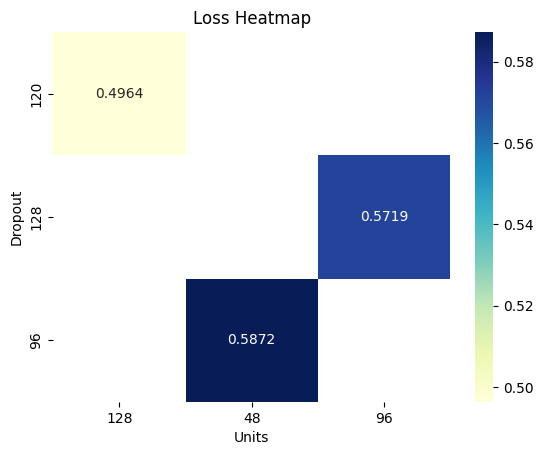

In [42]:
def read_mlflow_data(experiment_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_name])
    return runs

mlflow_data = read_mlflow_data('2')

def create_heatmap_data(mlflow_data):
    heatmap_data = mlflow_data[['params.filters', 'params.units1', 'metrics.Loss/test']]
    return heatmap_data

def plot_heatmap(heatmap_data):
    heatmap_pivot = heatmap_data.pivot(index='params.filters', columns='params.units1', values='metrics.Loss/test')
    sns.heatmap(heatmap_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.xlabel('Units')
    plt.ylabel('Dropout')
    plt.title('Loss Heatmap')
    plt.show()

heatmap_data = create_heatmap_data(mlflow_data)
plot_heatmap(heatmap_data)